In [1]:
import pandas as pd
import numpy as np
import datetime
import boto3
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import seaborn as sns
import scipy.stats as stats
import difflib
import re

In [2]:
#reads in sample of kiva data (10k rows)
loan = pd.read_csv('../data/sample_data.csv')

In [3]:
#first pass high level EDA
loan.info()
loan.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10000 non-null  int64  
 1   LOAN_ID                          10000 non-null  int64  
 2   LOAN_NAME                        9751 non-null   object 
 3   ORIGINAL_LANGUAGE                9773 non-null   object 
 4   DESCRIPTION                      9773 non-null   object 
 5   DESCRIPTION_TRANSLATED           7583 non-null   object 
 6   FUNDED_AMOUNT                    10000 non-null  float64
 7   LOAN_AMOUNT                      10000 non-null  float64
 8   STATUS                           10000 non-null  object 
 9   IMAGE_ID                         9773 non-null   float64
 10  VIDEO_ID                         4 non-null      float64
 11  ACTIVITY_NAME                    10000 non-null  object 
 12  SECTOR_NAME        

,Unnamed: 0,LOAN_ID,FUNDED_AMOUNT,LOAN_AMOUNT,IMAGE_ID,VIDEO_ID,CURRENCY_EXCHANGE_COVERAGE_RATE,PARTNER_ID,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9.773000e+03,4.000000,8077.000000,9907.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,1.029809e+06,747.275000,784.062500,2.041120e+06,2546.000000,0.107738,159.242859,13.906000,20.670800,1.554400,1.141300
std,2886.89568,5.663189e+05,971.591979,997.843864,9.386377e+05,1042.898205,0.033727,97.160638,7.765655,24.415152,1.060355,0.504935
min,0.00000,3.660000e+02,0.000000,25.000000,5.280000e+02,1015.000000,0.000000,5.000000,2.000000,0.000000,1.000000,1.000000
25%,2499.75000,5.447065e+05,250.000000,275.000000,1.340576e+06,2337.250000,0.100000,110.000000,8.000000,7.000000,1.000000,1.000000
50%,4999.50000,1.048266e+06,475.000000,500.000000,2.161870e+06,2935.000000,0.100000,145.000000,14.000000,13.000000,1.000000,1.000000
75%,7499.25000,1.542393e+06,875.000000,950.000000,2.865138e+06,3143.750000,0.100000,177.000000,14.000000,25.000000,2.000000,1.000000
max,9999.00000,2.017950e+06,10000.000000,10000.000000,4.012861e+06,3299.000000,0.200000,596.000000,98.000000,327.000000,22.000000,11.000000


In [4]:
def datetime_cleanup():
    #Converstion of str representations of datetime to datetime objects
    #Creation of new features to support analysis, dropping na values 

    loan['posted_datetime'] = pd.to_datetime(loan['POSTED_TIME'])
    loan['raised_datetime'] = pd.to_datetime(loan['RAISED_TIME'])
    loan['loan_speed'] = loan['raised_datetime']-loan['posted_datetime']
    loan['loanspeed_days'] = loan['loan_speed'] / pd.Timedelta(hours=24)
    loan.dropna(subset=['raised_datetime'], inplace=True)
    loan['loan_year'] = [loan['raised_datetime'][x].year for x in loan.index]

In [5]:
datetime_cleanup()

In [6]:
def count_borrowers(lst):
    #uses number of items in gender column to gauge number of borrowers
    if type(lst) != float:
        return len(lst.split(','))
    else:
        return 1

In [7]:
loan['borrower_n'] = loan['BORROWER_GENDERS'].apply(count_borrowers)


In [8]:
loan['BORROWER_GENDERS'].dropna()

0       female
1       female
2         male
3       female
4       female
         ...  
9995    female
9996    female
9997    female
9998      male
9999      male
Name: BORROWER_GENDERS, Length: 9284, dtype: object

In [9]:
#Function that returns gender state of loan, as male/female/mixed. This is necessary
#because the 'BORROWER_GENDERS' column is a string with the gender for each borrower
def gender_clean(lst):
    if re.findall('\\bmale\\b', str(lst)) and re.findall('\\bfemale\\b', str(list)):
        return 'mixed'
    elif not re.findall('\\bfemale\\b', str(lst)):
        return 'male'
    else:
        return 'female'

In [10]:
loan['gender_clean'] = loan['BORROWER_GENDERS'].apply(gender_clean)


In [11]:
loan['gender_clean']

0       female
1       female
2         male
3       female
4       female
         ...  
9995    female
9996    female
9997    female
9998      male
9999      male
Name: gender_clean, Length: 9500, dtype: object

In [12]:
#reads in csv of purchasing power parity values from world bank
#first four rows are skipped to avoid irrelevant metadata
ppp = pd.read_csv('../data/world_bank_ppp.csv', skiprows=4, index_col='Country Name')

In [13]:
ppp.head()

,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.543367,1.513201,1.509406,1.527644,1.496794,1.480481,1.497584,1.533552,NaN,NaN
Afghanistan,AFG,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.090013,17.656085,17.752737,17.194436,17.302048,17.360185,17.052368,17.134464,NaN,NaN
Angola,AGO,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.627365,79.540199,77.468643,77.784760,91.626457,107.269989,125.265871,144.052274,NaN,NaN
Albania,ALB,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.074543,54.480579,54.406343,52.629613,53.163815,52.647851,49.776943,49.559479,NaN,NaN
Andorra,AND,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def ppp_clean(ppp):
    #Check for spelling difference between country names in loan data and county names in ppp data
    ppp.reset_index(inplace=True)

    #set all countries names to lower case 
    loan['COUNTRY_NAME'] = [c.lower() for c in loan['COUNTRY_NAME']]
    ppp['Country Name'] = [c.lower() for c in ppp['Country Name']]

    #returns list of countries that are not matches between the data sets
    for c in set(loan['COUNTRY_NAME']):
        match_tup = (c, difflib.get_close_matches(c, ppp['Country Name'], cutoff=1))
        if match_tup[1] == []:
            print(match_tup[0]+'had no match')

    #Only 8 out of 82 countries are not matches. Most of the remaining difference are due to political
    #differences in naming; it is faster to manually rename this handful: 
    ppp = ppp.rename(index={'west bank and gaza':'palestine', 'congo, rep':'congo', 'myanmar ':'myanmar (burma)',
    'yemen, rep.':'yemen', 'lao pdr':'lao people''s democratic republic',
    'congo, dem. rep.':'the democratic republic of the congo', 'egypt arab rep.': 'egypt'})

    ppp.set_index('Country Name', inplace=True)

In [15]:
ppp_clean(ppp)

egypthad no match
myanmar (burma)had no match
palestinehad no match
lao people's democratic republichad no match
kyrgyzstanhad no match
yemenhad no match
the democratic republic of the congohad no match
congohad no match


In [16]:

def get_ppp_values(ppp, loan):

    ppp.set_index('Country Name', inplace=True)

    #creates list with country name and loan year from loan data
    holder = []
    for c,y in zip(loan['COUNTRY_NAME'], loan['loan_year']):
        holder.append([c,y])

    #selects appropriate ppp values from ppp data for each country and loan_year
    #if loan year is not found, algorithm will search back up to 2 years for most recent ppp
    for i in range(len(holder)):
        if holder[i][0] not in ppp.index:
            holder[i].append(np.nan)
        elif np.isnan(ppp.loc[holder[i][0], str(holder[i][1])]):
            if (ppp.loc[holder[i][0], str(holder[i][1]-1)]):
                holder[i].append(ppp.loc[holder[i][0], str(holder[i][1]-1)])
            elif (ppp.loc[holder[i][0], str(holder[i][1]-2)]):
                holder[i].append(ppp.loc[holder[i][0], str(holder[i][1]-2)])
            else:    
                holder[i].append(np.nan)
        else:
            holder[i].append(ppp.loc[holder[i][0],str(holder[i][1])])

    return holder

In [17]:
holder = get_ppp_values(ppp, loan)

In [18]:
def add_ppp_values(loan, holder):
    #Creates ppp value in loan datafarme
    loan['ppp'] = [holder[c][2] for c in range(len(holder))]

    #drops na values 
    loan['ppp'].dropna(inplace=True)

    #creates ppp_val column as product of ppp and loan_amount
    loan['loan_adj'] = loan['ppp'] * loan['LOAN_AMOUNT']

    return loan 

In [19]:
add_ppp_values(loan, holder)

,Unnamed: 0,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,...,DISTRIBUTION_MODEL,posted_datetime,raised_datetime,loan_speed,loanspeed_days,loan_year,borrower_n,gender_clean,ppp,loan_adj
0,0,822769,Ana Olaya,Spanish,En el cantón 24 De Mayo de la provincia de Ma...,"In the 24 De Mayo canton, Manabí province, kno...",825.0,825.0,funded,1772632.0,...,field_partner,2014-12-30 23:15:46+00:00,2015-01-26 21:41:32+00:00,26 days 22:25:46,26.934560,2015,1,female,0.580266,478.719498
1,1,758447,JOVELINE\t,English,Joveline is married and has two children. She ...,Joveline is married and has two children. She ...,525.0,525.0,funded,1677756.0,...,field_partner,2014-08-22 05:03:19+00:00,2014-09-02 15:48:57+00:00,11 days 10:45:38,11.448356,2014,1,female,19.067863,10010.628319
2,2,443481,JUAN ANGEL,Spanish,"Juan es un hombre de 54 años, es felizmente ca...","Juan, 54, is happily married. He lives with h...",400.0,400.0,funded,1127992.0,...,field_partner,2012-06-26 22:25:17+00:00,2012-07-26 03:01:16+00:00,29 days 04:35:59,29.191655,2012,1,male,1.572296,628.918314
3,3,943914,Delilah,English,Delilah is 45 years old and married with four ...,Delilah is 45 years old and married with four ...,225.0,225.0,funded,1972607.0,...,field_partner,2015-09-06 00:53:47+00:00,2015-09-14 13:35:36+00:00,8 days 12:41:49,8.529039,2015,1,female,19.038708,4283.709240
4,4,149321,Hurmatoy,English,K. Hurmatoy is a happy mother of three childre...,NaN,1575.0,1575.0,funded,418838.0,...,field_partner,2009-11-02 11:37:40+00:00,2009-11-02 21:24:33+00:00,0 days 09:46:53,0.407558,2009,1,female,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,537242,Ana,English,Ana is 21 years old and married with one child...,NaN,450.0,450.0,funded,1311558.0,...,field_partner,2013-03-13 07:39:30+00:00,2013-03-15 23:01:18+00:00,2 days 15:21:48,2.640139,2013,1,female,1.883895,847.752582
9996,9996,1197482,Liliane,French,Liliane continue a progressé dans son commerce...,Liliane continues to progress in her commerce....,250.0,250.0,funded,2379501.0,...,field_partner,2016-12-02 05:37:09+00:00,2016-12-04 23:48:22+00:00,2 days 18:11:13,2.757789,2016,1,female,27.211857,6802.964211
9997,9997,1032489,Ana Liza,English,Ana Liza is a hardworking woman entrepreneur.<...,Ana Liza is a hardworking woman entrepreneur.<...,225.0,225.0,funded,2116650.0,...,field_partner,2016-03-03 02:44:46+00:00,2016-03-06 18:13:36+00:00,3 days 15:28:50,3.645023,2016,1,female,18.925903,4258.328247
9998,9998,1488538,José Romel,Spanish,"José, tiene 40 años de edad, estudió hasta sép...",José is 40 years old. He went to school up to ...,600.0,600.0,funded,2796905.0,...,field_partner,2018-03-14 15:45:10+00:00,2018-04-04 07:21:50+00:00,20 days 15:36:40,20.650463,2018,1,male,0.508201,304.920734


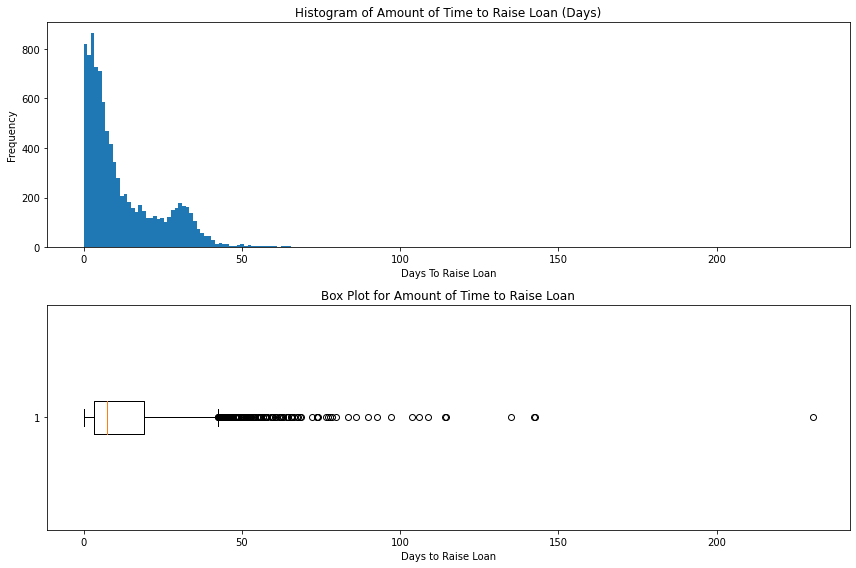

<Figure size 432x288 with 0 Axes>

In [20]:
#overview of loanspeed (amount of time taken to raise loan)

fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].hist(loan['loanspeed_days'], bins=200, label='histogram',)
ax[0].set_title('Histogram of Amount of Time to Raise Loan (Days)')
ax[0].set_xlabel('Days To Raise Loan')
ax[0].set_ylabel('Frequency')
ax[1].boxplot(loan['loanspeed_days'], vert=False)
ax[1].set_title('Box Plot for Amount of Time to Raise Loan')
ax[1].set_xlabel('Days to Raise Loan')
plt.tight_layout()
plt.show()
plt.savefig('../images/loan_histobox.png')


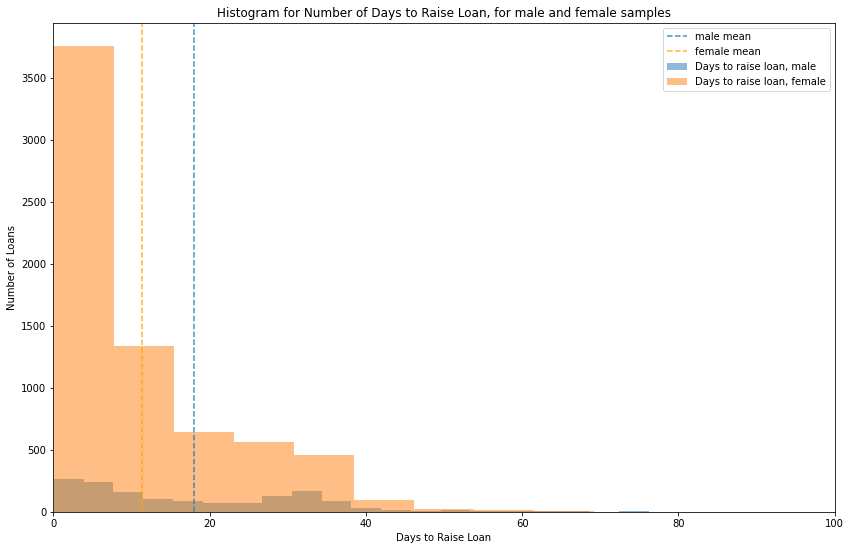

In [40]:
#gender
loanspeed_m = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='male']
loanspeed_f = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='female']

mean_male = np.mean(loanspeed_m)
mean_female = np.mean(loanspeed_f)

fig, ax = plt.subplots(figsize=(14,9))
ax.hist(loanspeed_m, bins=30, alpha=.5, label='Days to raise loan, male')
ax.axvline(mean_male, alpha=.8, linestyle='--', label='male mean')
ax.axvline(mean_female, alpha=.8, linestyle='--', color='orange', label='female mean')
ax.hist(loanspeed_f, bins=30, alpha=.5, label='Days to raise loan, female')
ax.set_xbound(0,100)
ax.legend(loc='upper right')
ax.set_xlabel('Days to Raise Loan')
ax.set_ylabel('Number of Loans')
ax.set_title('Histogram for Number of Days to Raise Loan, for male and female samples')

plt.savefig('../images/gender_histobox_aws.png')


In [39]:
#A quick visual of the histogram for male and female loanspeed shows that neither
#appears to be normally distributed, so a Mann-Whitney test is more appropriate 
#for gauging statistical significance:
mw_gender = stats.mannwhitneyu(loanspeed_m, loanspeed_f)

print("P-value {p} is far below alpha level of .05, so we reject null hypo.".format(p=mw_gender[1]))

P-value 4.326373415336906e-66 is far below alpha level of .05, so we reject null hypo.


In [ ]:
stats.mannwhitneyu(loanspeed_m, loanspeed_f)

In [56]:

for c in set(loan['COUNTRY_NAME']):
    c_loan = loan.loc[loan['COUNTRY_NAME']==c, 'loanspeed_days']
    if stats.shapiro(c_loan)[1] < .05:
        print('{country} is not normally distributed'.format(country=c))

#print(sum(loan['COUNTRY_NAME']=='brazil'))

egypt is not normally distributed
mongolia is not normally distributed
vietnam is not normally distributed
kenya is not normally distributed
samoa is not normally distributed


ValueError: Data must be at least length 3.

In [ ]:
#sector analysis
for x in set(loan['SECTOR_NAME']):
    if stats.ttest_ind(loan['loanspeed_days'][loan['SECTOR_NAME']==x], loan['loanspeed_days']
                       [loan['loanspeed_days']!=x],
                       alternative='two-sided')[1] < .05:
        
        print("Loans in {sector}, average of {mean} days to raise loan".format(sector=x,
                                                            mean=np.mean(loan['loanspeed_days']
                                                                         [loan['SECTOR_NAME']==x])))
    else:
        None


In [ ]:
#loan_amount vs. loanspeed
fig, ax = plt.subplots()
ax.scatter(loan['loanspeed_days'],loan['ppp_val'], alpha=.5)
plt.show()


In [ ]:
loan['ppp_val'].to_csv('ppp_val')

In [ ]:
loan['ppp'].describe()

In [ ]:
#Mean fulfillment speed of loan amounts, sized by n of loan amounts
loan_mean = loan.groupby(['ppp_val'])['loanspeed_days'].mean()
loan_count = loan.groupby(['ppp_val'])['ppp_val'].count()

#loan_count

#grouped.index
fig, ax = plt.subplots(figsize=(13,7))
ax.scatter(loan_mean.index, loan_mean, s=loan_count, alpha=.5)
ax.set_xlabel('Loan Value, adjusted for PPP')
ax.set_ylabel('Average # of Days to Raise Loan')
ax.set_title('Scatterplot of Average # of Days to Raise Loan by Loan Size, Sized by Number of Loans')


In [ ]:
fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].hist(loan['loanspeed_days'], bins=200, label='histogram',)
ax[0].set_title('Histogram of Amount of Time to Raise Loan (Days)')
ax[0].set_xlabel('Days To Raise Loan')
ax[0].set_ylabel('Frequency')
ax[1].boxplot(loan['loanspeed_days'], vert=False)
ax[1].set_title('Box Plot for Amount of Time to Raise Loan')
ax[1].set_xlabel('Days to Raise Loan')
plt.tight_layout()
plt.show()
plt.savefig('../images/histobox.png')







In [ ]:
stats.shapiro(loan['loanspeed_days'])

In [ ]:
stats.mannwhitneyu(loanspeed_m, loanspeed_f)

In [ ]:
loanspeed_m = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='male']
loanspeed_f = loan['loanspeed_days'][loan['BORROWER_GENDERS']=='female']

mean_male = np.mean(loanspeed_m)
mean_female = np.mean(loanspeed_f)

fig, ax = plt.subplots(figsize=(14,9))
ax.hist(loanspeed_m, bins=30, alpha=.5, label='Days to raise loan, male')
ax.axvline(mean_male, alpha=.8, linestyle='--')
ax.axvline(mean_female, alpha=.8, linestyle='--')
ax.hist(loanspeed_f, bins=30, alpha=.5, label='Days to raise loan, female')
ax.legend(loc='upper right')
ax.set_xlabel('Days to Raise Loan')
ax.set_ylabel('Number of Loans')
ax.set_title('Histogram for Number of Days to Raise Loan, for male and female samples')

plt.savefig('../images/gender_histogram_aws.png')